In [1]:
import csv
import os
from collections import defaultdict
from datetime import datetime
from datetime import timedelta

import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
sns.set()

In [3]:
%matplotlib inline

## Loading data

### Prestamos

In [4]:
%%time


dtypes = {
    'TITULO': str,
    'AUTOR': str,
    'SUCURSAL': str,
    'COD_BARRAS_LIBRO': str,
    'DEWEY': str,
    'DESC_LOCALIZACION_EJEMPLAR': str,
    'FECHA_PUB': str,
    'PAIS_EJEMPLAR': str,
    'OCUPACION': str,
    'NIVEL_EDUCACION': str,
    'AREA_ESTUDIO': str,
    'SUCURSAL_PRESTAMO': str,
    'SUCURSAL_DEVOLUCION': str,
    'SUCURSAL_DEL_LECTOR': str,
    'COD_BARRAS_LECTOR': str,
    'CATEGORÍA': str,
    'FECHA_PRESTAMO': str,
    'FECHA_REAL_DEVOLUCION': str,
    'DATE_PRESTAMO': str,
    'DATE_DEVOLUCION': str,
}

prestamos_df = pd.read_csv('prestamos_totales.csv', header=0, dtype=dtypes)
prestamos_df = prestamos_df.fillna('')

CPU times: user 12.5 s, sys: 1.19 s, total: 13.7 s
Wall time: 13.9 s


In [5]:
prestamos_df.shape

(3054360, 20)

In [6]:
prestamos_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
2,Quisiera tener ...,"Zoboli, Giovanna.",ARM,2284458,853,Infantil,2010,mx,,,,ARM,ARM,ARM,88381353,CTA,07/11/2015,17/11/2015,2015-11-07,2015-11-17
3,Johannes Gutenberg,"Borràs Perelló, Lluís.",ARM,2288922,925,Infantil,2010,sp,Empleado,Técnico,Adm. de empresas,ARM,ARM,ARM,88007424,CEM,16/01/2015,16/01/2015,2015-01-16,2015-01-16
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28


### Sucursales

In [7]:
sucursales = {
    'ARM': 'Armenia',
    'BLAA': 'Luis Angel Arango',
    'BUE': 'Buenaventura',
    'CAL': 'Cali',
    'CAR': 'Cartagena',
    'CASAGO': 'Casa Gómez Campuzano',
    'CATMAN': 'Catalogación y Mantenimiento de Colecciones',
    'CUC': 'Cúcuta',
    'FLO': 'Florencia',
    'GIR': 'Girardot',
    'HON': 'Honda',
    'IBA': 'Ibagué',
    'IEC': 'Investigaciones Económicas',
    'IPI': 'Ipiales',
    'LET': 'Leticia',
    'MAN': 'Manizales',
    'MED': 'Medellín',
    'MON': 'Montería',
    'NEI': 'Neiva',
    'PAS': 'Pasto',
    'PER': 'Pereira',
    'POP': 'Popayán',
    'QUI': 'Quibdó',
    'RIO': 'Riohacha',
    'SAN': 'San Andrés',
    'SIN': 'Sincelejo',
    'STM': 'Santa Marta',
    'TUN': 'Tunja',
    'VAL': 'Valledupar',
}

### Topics

0. Class 000 - Computer science, information & general works
1. Class 100 - Philosophy & psychology
2. Class 200 - Religion
3. Class 300 - Social sciences
4. Class 400 - Language
5. Class 500 - Science
6. Class 600 - Technology
7. Class 700 - Arts & recreation
8. Class 800 - Literature
9. Class 900 - History & geography

In [8]:
gdewey_dct = {
    '0': 'Computer science,\ninformation,\n& general works',
    '1': 'Philosophy & psychology',
    '2': 'Religion',
    '3': 'Social sciences',
    '4': 'Language',
    '5': 'Science',
    '6': 'Technology',
    '7': 'Arts & recreation',
    '8': 'Literature',
    '9': 'History & geography',
}

In [9]:
def keys(d):
    return sorted(d)

def values(d):
    return [d[k] for k in keys(d)]

In [10]:
topics = {}
with open('dewey.txt') as f:
    for line in f:
        chunks = line.strip().split()
        dewey = chunks[0]
        topic = ' '.join(chunks[1:])
        topics[dewey] = topic

### Usuarios

1.       CTA: categoría para niños y jóvenes hasta bachillerato
2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
3.       CTB: público general (solo permite préstamo de libros)
4.       CTC: público en general (permite préstamo de libros y material audiovisual)
5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
7.       CIS: categoría Inclusión Social
8.       CTU: categoría Universitaria
9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

0.     Categoría de lector: CE1 Categoría empresarial                                   218
1.     Categoría de lector: CE2 Categoría empresarial 2                                   5
2.     Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
3.     Categoría de lector: CIN Categoría Interbibliotecario                            128
4.     Categoría de lector: CIP Categoría Investigador                                  351
5.     Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
6.     Categoría de lector: CIV Categoría Investigadores                                 72
7.     Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
8.     Categoría de lector: CSU Categoría Sucursal                                       91
9.     Categoría de lector: CTA Categoría Básica A                                    10610
0.     Categoría de lector: CTB Categoría B                                            1359
1.     Categoría de lector: CTC Categoría C                                             224
2.     Categoría de lector: CTF Categoría familiar                                     1105
3.     Categoría de lector: CTI Categoría Infantil                                     1004
4.     Categoría de lector: CTU Categoría General                                     17402
5.     Categoría de lector: PTE PROCESOS TÉCNICOS                                       95

## Pre-processing data

In [11]:
prestamos_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
2,Quisiera tener ...,"Zoboli, Giovanna.",ARM,2284458,853,Infantil,2010,mx,,,,ARM,ARM,ARM,88381353,CTA,07/11/2015,17/11/2015,2015-11-07,2015-11-17
3,Johannes Gutenberg,"Borràs Perelló, Lluís.",ARM,2288922,925,Infantil,2010,sp,Empleado,Técnico,Adm. de empresas,ARM,ARM,ARM,88007424,CEM,16/01/2015,16/01/2015,2015-01-16,2015-01-16
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28


In [12]:
def group_dewey(x):
    try:
        int(x)
        r = x[0]
    except:
        r = ''
    return r

prestamos_df['GDEWEY'] = prestamos_df['DEWEY'].apply(group_dewey)

In [13]:
prestamos_df.CATEGORÍA.value_counts()

CTB    1241305
CTA     464123
CTC     412350
CTF     333510
CTU     151930
CEM     106300
CE1      80702
CSU      77940
CIS      64114
CIN      53376
CTI      36276
CE2      17398
CIV      11069
CIP       3958
CAN          8
CE3          1
Name: CATEGORÍA, dtype: int64

In [14]:
def get_year(x):
    return x.split('/')[-1]

prestamos_df['YEAR'] = prestamos_df['FECHA_PRESTAMO'].apply(get_year)

In [15]:
prestamos_df.YEAR.value_counts().sort_index()

2012    677551
2013    658150
2014    607554
2015    548997
2016    562108
Name: YEAR, dtype: int64

In [16]:
p_df = prestamos_df[prestamos_df['GDEWEY'] != '']

In [17]:
p_df.GDEWEY.value_counts()

8    923712
3    701250
6    257117
7    239411
1    210738
9    207929
5    198839
0     82294
2     55328
4     46178
Name: GDEWEY, dtype: int64

In [18]:
p_df.shape

(2922796, 22)

## Processing data

### Query #1

In [19]:
query1a_sr = p_df.groupby(['CATEGORÍA', 'GDEWEY']).TITULO.count()
query1b_sr = p_df.groupby(['GDEWEY', 'CATEGORÍA']).TITULO.count()

In [20]:
query1a_sr.head()

CATEGORÍA  GDEWEY
CAN        3             4
CE1        0          2947
           1          5263
           2          1299
           3         18307
Name: TITULO, dtype: int64

In [21]:
query1b_sr.head()

GDEWEY  CATEGORÍA
0       CE1          2947
        CE2           569
        CEM          3958
        CIN          2588
        CIP            76
Name: TITULO, dtype: int64

In [22]:
# q1_g = nx.DiGraph()
# for (category, gdewey), n in query1a_sr.iteritems():
#     if category not in q1_g:
#         a = query1a_sr[category].sum()
#         q1_g.add_node(category, type='User category', weight=int(a))
#     if gdewey not in q1_g:
#         b = query1b_sr[gdewey].sum()
#         q1_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
#     q1_g.add_edge(category, gdewey_dct[gdewey], weight=int(n))

In [41]:
q1_g = nx.Graph()
for (category, gdewey), n in query1a_sr.iteritems():
    if category not in q1_g:
        a = query1a_sr[category].sum()
        q1_g.add_node(category, type='User category', weight=int(a))
    if gdewey not in q1_g:
        b = query1b_sr[gdewey].sum()
        q1_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
    q1_g.add_edge(category, gdewey_dct[gdewey], weight=int(n))

In [42]:
q1_g.number_of_nodes()

26

In [43]:
q1_g.number_of_edges()

142

In [44]:
q1_g.number_of_selfloops()

0

In [45]:
# nx.write_gexf(q1_g, 'queries/q1.gexf')

In [47]:
list(nx.bridges(q1_g))

[('CE3', 'Religion'), ('Social sciences', 'CAN')]

### Query #2

In [27]:
query2a_sr = p_df.groupby(['SUCURSAL', 'GDEWEY']).TITULO.count()
query2b_sr = p_df.groupby(['GDEWEY', 'SUCURSAL']).TITULO.count()

In [28]:
query2a_sr.head()

SUCURSAL  GDEWEY
ARM       0          609
          1          258
          2          124
          3         1249
          4           39
Name: TITULO, dtype: int64

In [29]:
query2b_sr.head()

GDEWEY  SUCURSAL
0       ARM           609
        BLAA        50338
        BUE           116
        CAL           101
        CAR           977
Name: TITULO, dtype: int64

In [30]:
# q2_g = nx.DiGraph()
# for (branch, gdewey), n in query2a_sr.iteritems():
#     if branch not in q2_g:
#         a = query2a_sr[branch].sum()
#         q2_g.add_node(branch, type='Library branch', weight=int(a))
#     if gdewey not in q2_g:
#         b = query2b_sr[gdewey].sum()
#         q2_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
#     q2_g.add_edge(branch, gdewey_dct[gdewey], weight=int(n))

In [48]:
q2_g = nx.Graph()
for (branch, gdewey), n in query2a_sr.iteritems():
    if branch not in q2_g:
        a = query2a_sr[branch].sum()
        q2_g.add_node(branch, type='Library branch', weight=int(a))
    if gdewey not in q2_g:
        b = query2b_sr[gdewey].sum()
        q2_g.add_node(gdewey_dct[gdewey], type='Dewey class', weight=int(b))
    q2_g.add_edge(branch, gdewey_dct[gdewey], weight=int(n))

In [49]:
q2_g.number_of_nodes()

39

In [50]:
q2_g.number_of_edges()

279

In [51]:
q2_g.number_of_selfloops()

0

In [34]:
# nx.write_gexf(q2_g, 'queries/q2.gexf')

In [52]:
list(nx.bridges(q2_g))

[('IEC', 'Social sciences')]

### Query #4

In [35]:
query4_sr = p_df.groupby(['YEAR', 'GDEWEY']).TITULO.count()
query4_df = query4_sr.unstack('GDEWEY')

In [36]:
query4_df

GDEWEY,0,1,2,3,4,5,6,7,8,9
YEAR,,,,,,,,,,
2012,18249,49104,13029,158962,10008,50940,67045,56487,173241,45393
2013,16755,46765,12484,153684,9689,44408,59110,52986,186139,45448
2014,16067,43143,11171,141896,9739,38843,51125,48033,182096,42628
2015,15243,36974,9578,125755,8309,32325,40963,41588,181592,37330
2016,15980,34752,9066,120953,8433,32323,38874,40317,200644,37130


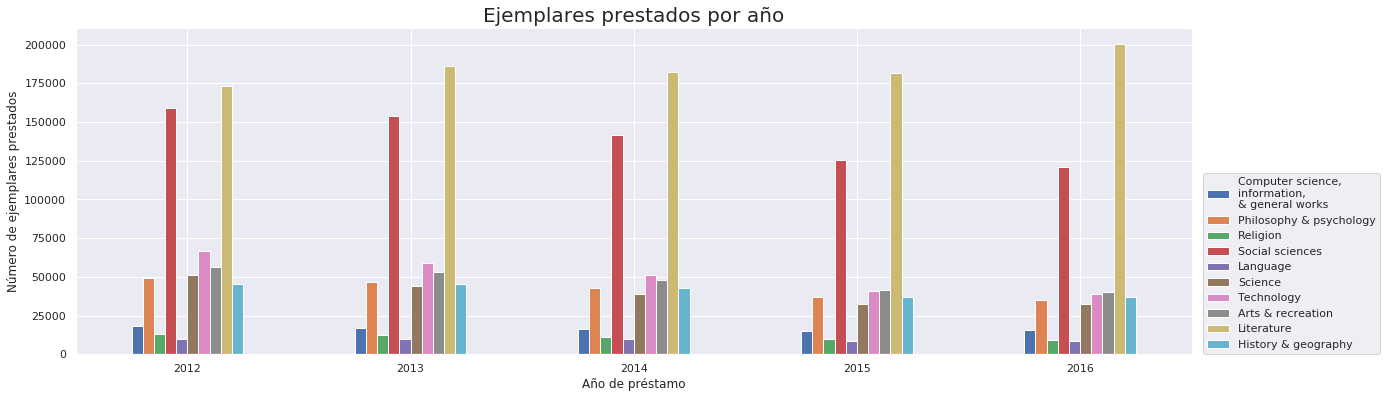

In [37]:
ax = query4_df.plot(
    kind='bar',
    figsize=(20, 6),
    rot=0,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, values(gdewey_dct), loc=(1.01, 0))#, prop={'size': 10})
ax.set(xlabel='Año de préstamo', ylabel='Número de ejemplares prestados')
ax.set_title('Ejemplares prestados por año', fontsize=20);

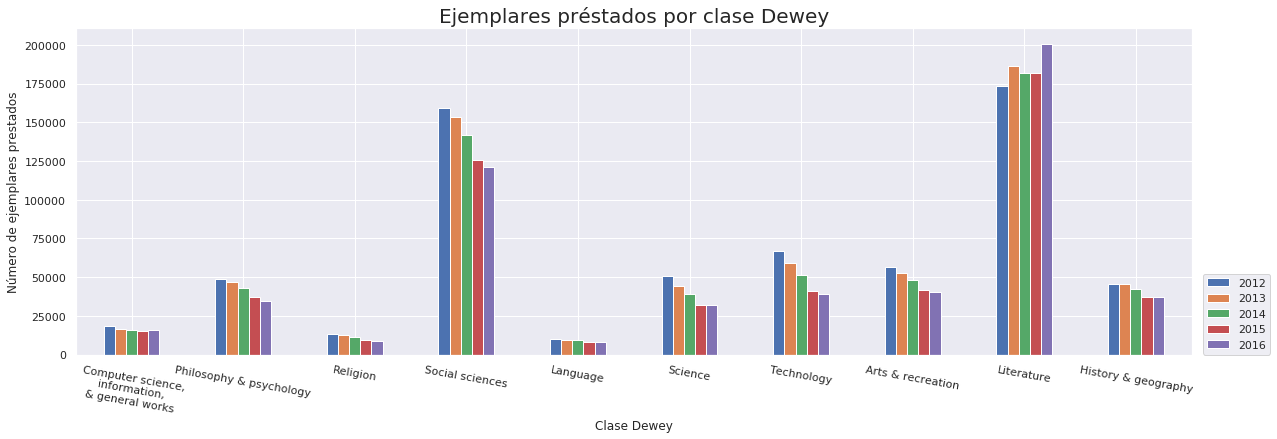

In [38]:
bx = query4_df.T.plot(
    kind='bar',
    figsize=(20, 6),
    rot=-10,
)
handles, labels = bx.get_legend_handles_labels()
bx.legend(handles, labels, loc=(1.01, 0))#, prop={'size': 10})
bx.set(xlabel='Clase Dewey', ylabel='Número de ejemplares prestados')
bx.set_xticklabels(values(gdewey_dct))
bx.set_title('Ejemplares préstados por clase Dewey', fontsize=20);